In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['source']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [38]:
import pyhf
import logging
logging.basicConfig(level = logging.INFO)
from pyhf import hfpdf
def prep_data(sourcedata):
    spec =  {
        'signal': {
            'signal': {
                'data': sourcedata['signal']['bindata']['sig'],
                'mods': [
                    {
                        'name': 'mu',
                        'type': 'normfactor',
                        'data': None
                    }
                ]
            },
            'bkg1': {
                'data': sourcedata['signal']['bindata']['bkg1'],
                'mods': [
                    {
                        'name': 'coupled_shapefactor',
                        'type': 'shapefactor',
                        'data': None
                    }
                ]
            }
        },
        'control': {
            'background': {
                'data': sourcedata['control']['bindata']['bkg1'],
                'mods': [
                    {
                        'name': 'coupled_shapefactor',
                        'type': 'shapefactor',
                        'data': None
                    }
                ]
            }
        }
    }
    pdf  = hfpdf(spec)
    data = []
    for c in pdf.config.channel_order:
        data += sourcedata[c]['bindata']['data']
    data = data + pdf.config.auxdata
    return data, pdf

In [39]:
import json

source = {
  "channels": {
    "signal": {
      "binning": [2,-0.5,1.5],
      "bindata": {
        "data":     [220.0, 230.0],
        "bkg1":     [100.0, 70.0],
        "sig":      [ 20.0, 20.0]
      }
    },
    "control": {
      "binning": [2,-0.5,1.5],
      "bindata": {
        "data":    [200.0, 300.0],
        "bkg1":    [100.0, 100.0]
      }
    }
  }
}

d,pdf = prep_data(source['channels'])

print (d)

init_pars = pdf.config.suggested_init()


print pdf.expected_data(init_pars)

par_bounds = pdf.config.suggested_bounds()

# unconpars = pyhf.unconstrained_bestfit(d,pdf,init_pars,par_bounds)
# print ('UNCON',unconpars)

# conpars = pyhf.constrained_bestfit(0.0,d,pdf,init_pars,par_bounds)
# print ('CONS', conpars)

# pdf.expected_data(conpars)

INFO:pyhf:adding modifier coupled_shapefactor (2 new nuisance parameters)
INFO:pyhf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf:accepting existing unconstrained factor 


[200.0, 300.0, 220.0, 230.0]
[100. 100. 120.  90.]


In [40]:
print pdf.config.suggested_init()

unconpars = pyhf.unconstrained_bestfit(d,pdf,pdf.config.suggested_init(),pdf.config.suggested_bounds())
print ('UNCON',unconpars)


[1.0, 1.0, 1.0]
('UNCON', array([1.99998945, 3.00000473, 1.00004452]))


/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:341: RuntimeWarning: divide by zero encountered in log
  


/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:401: RuntimeWarning: divide by zero encountered in double_scalars
  


{'exp': [0.7413811114983857,
  0.9949349478730988,
  1.384513834251305,
  1.9289936989205811,
  2.59407652367884],
 'obs': 2.1945969217530887}

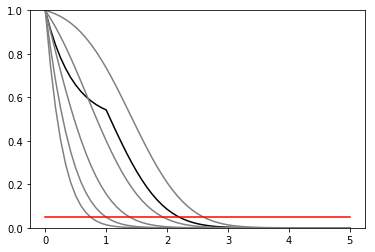

In [41]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def CLsOnePoint(muTest,d,pdf, init_pars,par_bounds):
    clsobs, cls_exp = pyhf.runOnePoint(muTest, d,pdf,init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross


CLsOnePoint(1.0,d,pdf,init_pars,par_bounds)


mutests = np.linspace(0,5,61)
tests = [CLsOnePoint(muTest,d,pdf,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)
invert_interval(mutests, cls_obs, cls_exp)